# 1. Setup

### Installation

In [2]:
!pip install opencv-python matplotlib tensorflow

  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
  Using cached tensorflow-2.12.0-cp310-cp310-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.12.0-cp310-cp310-win_amd64.whl (272.8 MB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl (440 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl (1.5 MB)
  Using cached tensorboard-2.12.3-py3-none-any.whl (5.6 MB)
  Using cached libclang-16.0.0-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached jax-0.4.10.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Gett

### Import Packages

In [3]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPooling2D, Dense, Flatten

In [5]:
# Some experimental functions that are needed, otherwise errors are thrown
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [6]:
# When utilizing a GPU, ensure that we don't run out of memory
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[]


### Configure Directories

In [7]:
# Anchor images are those taken by the webcam. Positive images are also of me, negative images are of random people
POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

In [7]:
# Create these directories if they don't already exist
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2. Collect Images

### Negative Image Database: http://vis-www.cs.umass.edu/lfw/


In [8]:
# Unzip Labeled Faces in the Wild dataset
!tar -xf lfw.tgz

In [9]:
# Move all LFW images to the "data\negative" directory
for directory in os.listdir("lfw"):
    for file in os.listdir(os.path.join("lfw", directory)):
        file_path = os.path.join("lfw", directory, file)
        new_path = os.path.join(NEG_PATH, file)
        os.replace(file_path, new_path)

### Collect Positive and Anchor Images using Camera

In [8]:
# UUID is used to generate unique file names for each image we collect
import uuid

In [182]:
# Connect to the webcam. The number inside VideoCapture(#) may need to be adjusted.
video = cv2.VideoCapture(1)

while True:
    ret, frame = video.read()
    frame = cv2.flip(frame, 1)
    
    # Resize the frame to 250x250x3 because all files must have the same dimensions as LFW images
    # Other numbers represent approximate face location
    frame = frame[115:115+250, 190:190+250, :]
    
    # Collect anchors when 'a' is pressed
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create a unique file name
        img_path = os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(img_path, frame)
    
    # Collect positives when 'p' is pressed
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create a unique file name
        img_path = os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(img_path, frame)
    
    cv2.imshow("Video Feed", frame)
    
    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

### Data Augmentation

In [9]:
# Create 9 copies of an image with random with random mutations (brightness, contrast, flip, quality, saturation)
# Makes the model more generalizable to different images
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [ ]:
# Runs data augmentation for every anchor and positive image, saving them in the appropriate folders
# DO NOT EXECUTE UNTIL DATA IS IMPORTED

for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load Images


In [198]:
# Load images into TensorFlow Dataloader - takes 3000 from each directory - larger dataset improves model accuracy
anchor = tf.data.Dataset.list_files(ANC_PATH + "/*.jpg").take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + "/*.jpg").take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + "/*.jpg").take(3000)

In [129]:
# Proof of concept
anchor_test = anchor.as_numpy_iterator()
anchor_test.next()

b'data\\anchor\\08b7af44-f82d-11ed-8322-9cb6d0c97f20.jpg'

### Preprocess images

In [10]:
# Resize and scale images
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    # Resize image to 100x100x3 - necessary for the neural network because shapes are standardized
    img = tf.image.resize(img, (100, 100))
    # Scale image by dividing every value by 255 
    img /= 255.0
    
    return img

In [185]:
# Sanity check
preprocess(b'data\\anchor\\00c99220-fccb-11ed-8108-9cb6d0c97f20.jpg')

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.60294116, 0.6382353 , 0.6343137 ],
        [0.6039216 , 0.6392157 , 0.63529414],
        [0.6009804 , 0.6362745 , 0.63235295],
        ...,
        [0.6227941 , 0.65416664, 0.66593134],
        [0.6227941 , 0.65416664, 0.6629902 ],
        [0.6245098 , 0.65588236, 0.6637255 ]],

       [[0.60318625, 0.63848037, 0.6345588 ],
        [0.6071078 , 0.64240193, 0.63848037],
        [0.60490197, 0.6401961 , 0.6362745 ],
        ...,
        [0.62034315, 0.6517157 , 0.6634804 ],
        [0.622549  , 0.65392154, 0.6634804 ],
        [0.622549  , 0.65588236, 0.6627451 ]],

       [[0.6017157 , 0.6370098 , 0.63308823],
        [0.6039216 , 0.6392157 , 0.63529414],
        [0.6039216 , 0.6392157 , 0.63529414],
        ...,
        [0.62034315, 0.6517157 , 0.6634804 ],
        [0.62034315, 0.65612745, 0.6634804 ],
        [0.61960787, 0.65882355, 0.6627451 ]],

       ...,

       [[0.37916666, 0.33112746, 0.26838234],
        [0.38

### Label the Data

(anchor, positive) -> 1,
(anchor, negative) -> 0

In [200]:
# Assign (anchor, positive) pairs to 1, and (anchor, negative) pairs to 0. Finally, concatenate both into "data"
positive_labels = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negative_labels = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positive_labels.concatenate(negative_labels)

In [10]:
# Sanity check
sample_data = data.as_numpy_iterator().next()
sample_data

(b'data\\anchor\\03db0100-f82d-11ed-bd8f-9cb6d0c97f20.jpg',
 b'data\\positive\\65891631-f83d-11ed-a82f-9cb6d0c97f20.jpg',
 1.0)

### Partition Data into Train and Test groups

In [201]:
# Links an input (anchor) and validation (positive/negative) image with the assigned label into a tuple
def link_pairs(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [35]:
# Sanity check
match = link_pairs(*sample_data)
plt.imshow(match[1])

In [202]:
# Building the data pipeline
# Applies the link_pairs function to all the data
data = data.map(link_pairs)
# Caches the data, storing it in memory for quick access
data = data.cache()
# Shuffles data randomly - large buffer size = uniform shuffling
data = data.shuffle(buffer_size=10000)

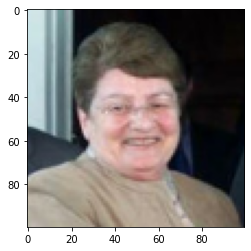

In [47]:
# Sanity check (again)
sample = data.as_numpy_iterator()
plt.imshow(sample.next()[1])

In [203]:
# Training partition - 70% of data
train_data = data.take(round(len(data)*.7))
# Assort the data into batches of 16, processing it quickly
train_data = train_data.batch(16)
# Fetch the next 8 pieces of data before finishing processing the current batch, reducing step time
train_data = train_data.prefetch(8)

In [204]:
# Testing partition - 30% of data
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Build the Model!

### Following the architecture described in this paper: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

### Create Embedding 

In [15]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name="input_image")
    
    # Block 1
    conv1 = Conv2D(64, (10,10), activation="relu")(inp)
    mp1 = MaxPooling2D(64, (2,2), padding="same")(conv1)
    
    # Block 2
    conv2 = Conv2D(128, (7,7), activation="relu")(mp1)
    mp2 = MaxPooling2D(64, (2,2), padding="same")(conv2)
    
    # Block 3
    conv3 = Conv2D(128, (4,4), activation="relu")(mp2)
    mp3 = MaxPooling2D(64, (2,2), padding="same")(conv3)
    
    # Block 4
    conv4 = Conv2D(256, (4,4), activation="relu")(mp3)
    # Transform into the 4096 length fully-connected layer
    f1 = Flatten()(conv4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    
    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [16]:
embedding_model = make_embedding()
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Create Distance Layer

In [12]:
class L1Dist(Layer):
    # Inheritance of the Layer class
    def __init__(self, **kwargs):
        super().__init__()
    
    # Calculate distance (similarity)
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [18]:
l1 = L1Dist()
l1

### Create Siamese Model

In [32]:
def make_siamese_model():
    input_img = Input(name="input_img", shape=(100,100,3))
    validation_img = Input(name="validation_img", shape=(100,100,3))
    
    # Combine the distances
    distance_layer = L1Dist()
    distance_layer._name = "distance"
    distances = distance_layer(embedding_model(input_img), embedding_model(validation_img))
    
    # Classification layer: 4096 -> 1
    classifier = Dense(1, activation="sigmoid")(distances)
    
    return Model(inputs=[input_img, validation_img], outputs=classifier, name="SiameseNetwork")

In [34]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Model Training

### Create Loss Function and Optimizer

In [28]:
# Using Binary Cross-Entropy Loss
loss_function = tf.losses.BinaryCrossentropy()
# Adam optimizer - an extension of Stochastic Gradient Descent
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

### Establish Checkpoints

In [22]:
checkpoint_dir = "./training_checkpoints"
# os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "cpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### Build Training Step

In [29]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        imgs = batch[:2]
        labels = batch[2]
        
        # Forward pass
        predicted_labels = siamese_model(imgs, training=True)
        # Calculate loss
        loss = loss_function(labels, predicted_labels)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Backpropagation 
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

### Training Loop


In [38]:
def train(data, epochs):
    losses = []
    recalls = []
    precisions = []
    for epoch in range(1, epochs+1):
        print("Epoch {}/{}".format(epoch, epochs))
        progress_bar = tf.keras.utils.Progbar(len(train_data))
        
        # Create metrics
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for index, batch in enumerate(data):
            loss = train_step(batch)
            prediction = siamese_model.predict(batch[:2])
            
            r.update_state(batch[2], prediction)
            p.update_state(batch[2], prediction)
            progress_bar.update(index+1)
        
        print("Loss: {} \nRecall: {} \nPrecision: {} \n".format(loss.numpy(), r.result().numpy(), p.result().numpy()))
        losses.append(loss.numpy())
        recalls.append(r.result().numpy())
        precisions.append(r.result().numpy())
        
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train the Model

In [59]:
epochs = 50
train(train_data, epochs)

Epoch 1/50
27/27 [==============================] - 593s 22s/step
0.43880916

Epoch 2/50
27/27 [==============================] - 593s 22s/step
0.085534856

Epoch 3/50
23/27 [========================>.....] - ETA: 1:31

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

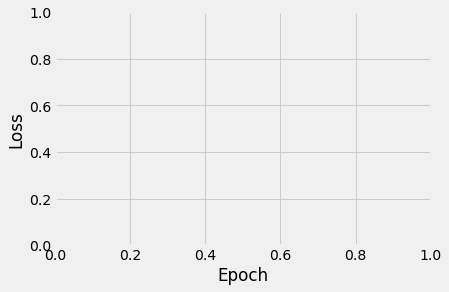

In [136]:
# Plot losses
plt.style.use("fivethirtyeight")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.plot(losses)

# 6. Evaluate Model

In [60]:
# Import Precision and Recall
# Precision is what proportion of positive identifications are correct
# Recall is what proportion of actual positives are identified correctly
from tensorflow.keras.metrics import Precision, Recall

### Make Predictions

In [206]:
# Get a batch of test data
test_input, test_validation, labels = test_data.as_numpy_iterator().next()

In [145]:
# Make predictions
prediction = model.predict([test_input, test_validation])
prediction

1/1 [==============================] - 1s 845ms/step


array([[2.0623540e-05],
       [9.9999964e-01],
       [1.0000000e+00],
       [9.3952560e-01],
       [6.9799671e-07],
       [1.0729127e-08],
       [2.7228268e-08],
       [2.8388524e-07],
       [9.9999875e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [8.1881130e-01],
       [5.8585609e-08],
       [9.7625377e-07],
       [4.3846593e-10],
       [1.0000000e+00]], dtype=float32)

In [146]:
# List comprehension
[1 if pred > 0.5 else 0 for pred in prediction]

[0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]

In [148]:
labels

array([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.],
      dtype=float32)

### Calculate Metrics

In [119]:
r = Recall()
p = Precision()

for test_input, test_validation, labels in test_data.as_numpy_iterator():
    prediction = siamese_model([test_input, test_validation])
    r.update_state(labels, prediction)
    p.update_state(labels, prediction)

print(r.result().numpy(), p.result().numpy())
# 98.9 % of true positives are identified correctly, and 100% of positive identifications are true positives

0.98888886 1.0


### Visualize Results

1.0


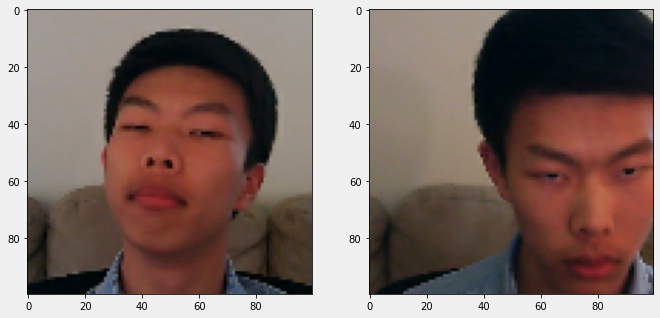

In [150]:
i = 8
plt.figure(figsize=(10, 8))
plt.style.use("default")

# Show Anchor image
plt.subplot(1, 2, 1)
plt.imshow(test_input[i])

# Show Positive/Negative image
plt.subplot(1, 2, 2)
plt.imshow(test_validation[i])

print(labels[i])
plt.show()

# 7. Save Model

In [ ]:
# Save weights
siamese_model.save("siamesemodelv2.h5")

In [13]:
# Reload model
model = tf.keras.models.load_model("siamesemodelv2.h5", 
                                   custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy":tf.losses.BinaryCrossentropy})

In [207]:
model.predict([test_input, test_validation])

1/1 [==============================] - 1s 657ms/step


array([[1.4688931e-03],
       [8.7172311e-04],
       [2.1888616e-03],
       [1.8734224e-04],
       [1.0478302e-03],
       [1.8556869e-04],
       [7.4147864e-04],
       [9.5325023e-01],
       [9.9749506e-01],
       [7.0859390e-01],
       [8.4235883e-01],
       [3.7861374e-04],
       [8.4873885e-01],
       [3.9520087e-03],
       [9.9974817e-01],
       [9.8905033e-01]], dtype=float32)

In [188]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Full Test

### Verification Function

In [14]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join("application_data", "verification_images")):
        input_img = preprocess(os.path.join("application_data", "input_image", "input_image.jpg"))
        validation_img = preprocess(os.path.join("application_data", "verification_images", image))
        
        # Make Predictions
        result = model(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Calculate the proportion of predicted results that are positive
    detection_total = np.sum(np.array(results) > detection_threshold)
    verification = detection_total/len(os.listdir(os.path.join("application_data", "verification_images")))
    verdict = verification > verification_threshold
    
    return results, verdict

### OpenCV Verification

In [21]:
video = cv2.VideoCapture(1)

while video.isOpened():
    ret, frame = video.read()
    frame = cv2.flip(frame, 1)

    frame = frame[115:115+250, 190:190+250, :]
    
    cv2.imshow("Verification", frame)
    
    # Do verification
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to input_image folder
        cv2.imwrite(os.path.join("application_data", "input_image", "input_image.jpg"), frame)
        
        # Run verification
        results, verdict = verify(model, 0.5, 0.5)
        print(verdict)
        
    # Exit loop
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

True
True


In [194]:
# Gather Verification Images
import shutil

all_positives = os.listdir(POS_PATH)
random.shuffle(all_positives)
# take the first 50 shuffled positive images
verification_imgs = all_positives[:50]

for path in verification_imgs:
    new_path = os.path.join("application_data", "verification_images", path)
    file_path = os.path.join(POS_PATH, path)
    shutil.copy2(file_path, new_path)

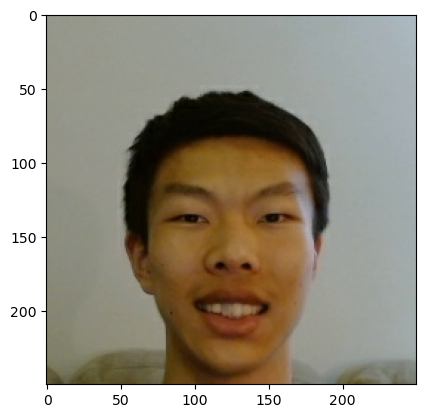

In [22]:
# Display image 
file_path = os.path.join("application_data", "input_image", "input_image.jpg")
byte_img = tf.io.read_file(file_path)
img = tf.io.decode_jpeg(byte_img)
plt.imshow(img)

In [23]:
np.squeeze(results)

array([0.834828  , 0.9683296 , 0.949437  , 0.988848  , 0.9929682 ,
       0.9990281 , 0.99893945, 0.99960995, 0.9998657 , 0.99791825,
       0.99642175, 0.99381465, 0.94369996, 0.97955966, 0.9803083 ,
       0.9394383 , 0.9659141 , 0.97245044, 0.9552118 , 0.9700502 ,
       0.98945034, 0.98101693, 0.98388284, 0.9594957 , 0.9877897 ,
       0.992158  , 0.9854855 , 0.9961706 , 0.9822856 , 0.97200346,
       0.9996932 , 0.9996917 , 0.9991368 , 0.98630226, 0.99053067,
       0.9378518 , 0.99568987, 0.9969282 , 0.99600255, 0.99695164,
       0.9992839 , 0.9995534 , 0.99957895, 0.9991315 , 0.9950294 ,
       0.9961903 , 0.9952245 , 0.98947537, 0.99754894, 0.9988449 ],
      dtype=float32)

In [197]:
np.sum(np.squeeze(results) > 0.9)

49

In [26]:
def verify2(model, detection_threshold, verification_threshold):
    input_img = preprocess(os.path.join("application_data", "test_images", "test_image1.jpg"))
    validation_img = preprocess(os.path.join("application_data", "test_images", "test_image2.jpg"))
        
    # Make Predictions
    result = model(list(np.expand_dims([input_img, validation_img], axis=1)))
    
    # Calculate the proportion of predicted results that are positive
#     detection_total = np.sum(np.array(results) > detection_threshold)
#     verification = detection_total/len(os.listdir(os.path.join("application_data", "verification_images")))
    verdict = result > verification_threshold
    
    return result, verdict

In [27]:
video = cv2.VideoCapture(1)

while video.isOpened():
    ret, frame = video.read()
    frame = cv2.flip(frame, 1)

    frame = frame[115:115+250, 190:190+250, :]
    
    cv2.imshow("Verification", frame)
    
    if cv2.waitKey(10) & 0xFF == ord('a'):
        cv2.imwrite(os.path.join("application_data", "test_images", "test_image1.jpg"), frame)
    
    # Do verification
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Run verification
        result, verdict = verify2(model, 0.5, 0.5)
        print(result, verdict)
        
    # Exit loop
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

tf.Tensor([[0.60816383]], shape=(1, 1), dtype=float32) tf.Tensor([[ True]], shape=(1, 1), dtype=bool)
tf.Tensor([[0.60816383]], shape=(1, 1), dtype=float32) tf.Tensor([[ True]], shape=(1, 1), dtype=bool)
